## Libraries

In [1]:
using KadanoffBaym, LinearAlgebra, BlockArrays
using Bessels
using PyPlot
using Tullio
⊗(A,B) = kron(A,B)

⊗ (generic function with 1 method)

## Parameters and predifined quantities

In [2]:
hbar = 1.#0.658211928e0  
### Pauli matrices
σ_0 = Matrix{ComplexF64}([1. 0. ; 0 1])
σ_x =  Matrix{ComplexF64}([0 1; 1 0])
σ_y =  Matrix{ComplexF64}([0 -1im ; 1im 0 ])
σ_z = Matrix{ComplexF64}([1 0. ; 0. -1]) ; 

In [3]:
# Lattice size
L = 2
nσ = 2
nx = L
ny = 1
γ = 1
γso = 0
j_sd = 0.1
# Allocate the initial Green functions (time arguments at the end)
GL = GreenFunction(zeros(ComplexF64, nx*nσ, nx*nσ, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, nx*nσ, nx*nσ, 1, 1), SkewHermitian);
#####Ht = GreenFunction(zeros(ComplexF64, nx*nσ, nx*nσ, 1, 1), SkewHermitian);
# GL_d = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian)
# GG_d = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian);

In [4]:
I_a1b1 = Matrix{ComplexF64}(I, L, L)            # Identity on lattice space
I_ab = Matrix{ComplexF64}(I, nσ*L, nσ*L)        # Identity on lattice ⊗ spin
# --- Pauli matrices extended to the full Hilbert space ---
σ_x1ab = kron(I_a1b1, σ_x)
σ_x2ab = kron(I_a1b1, σ_y)
σ_x3ab = kron(I_a1b1, σ_z)
# --- Pauli matrices as a 3D array σ_abx[μ, i, j] ---
σ_ijx = cat(σ_x1ab, σ_x2ab, σ_x3ab; dims=3) ;

### Auxiliary integrator

In [5]:
function integrate0(t1,t2,A)
    retval = 0.0 + 0.0im
    dt = 0.01
    ts = t2:dt:t1
    A_vec = A.(ts)
    @tullio retval = A_vec[α]
    retval = retval*dt
end
# Auxiliary integrator for the first type of integral
function integrate1(hs::Vector, t1, t2, A::GreenFunction, B::GreenFunction, C::GreenFunction; tmax=t1)
    retval = zero(A[t1, t1])
    @inbounds for k in 1:tmax
        @views LinearAlgebra.mul!(retval, A[t1, k] - B[t1, k], C[k, t2], hs[k], 1.0)
    end
    return retval
end
# Auxiliary integrator for the second type of integral
function integrate2(hs::Vector, t1, t2, A::GreenFunction, B::GreenFunction, C::GreenFunction; tmax=t2)
    retval = zero(A[t1, t1])
    @inbounds for k in 1:tmax
        @views LinearAlgebra.mul!(retval, A[t1, k], B[k, t2] - C[k, t2], hs[k], 1.0)
    end
    return retval
end

integrate2 (generic function with 1 method)

### Precesion 

In [6]:
mutable struct PrecSpin
    """ This mutable structure act like a class 
    in python, it defines an object with the 
    characteristics of a precessing spin
    """
    i::Int64 #   
    axis_phi::Float64 
    axis_theta::Float64 
    phi_zero::Float64 
    theta_zero::Float64 
    start_time::Float64 
    T::Float64 
    s::Vector{Float64} 
    ### Initial values of PrecSpin .
    function PrecSpin(i=0,axis_phi=0.0,axis_theta=0.0,
            phi_zero=0.0,theta_zero=0.0,start_time=0.0
            ,T=1.,s=[0.,0.,1.])
        new(i,axis_phi,axis_theta,phi_zero,theta_zero,start_time,T,s)
    end
end

function update!(this::PrecSpin, time  )
    """ This function  update the magnetic moment associated
    to the mutable structure PrecSpin 
    
    parameters:
    ----------
    this: mutable structure 
    contain an structure with the characteristics of a spin 
    time: Float64
    time where the spin is evaluated 
    
    returns:
    -------
    Update the strucure associated to a  precessing spin 
    """
    if time >= this.start_time
        t = time - this.start_time
    else
        t = 0.0
    end
    omega = 2*pi / this.T
    otheta = pi*this.theta_zero/180.
    ophi = pi*this.phi_zero /180. ##########
    # compute spin position for precession along the z-axis
    sz = cos(otheta)
    sx = cos(ophi + omega*t)*sin(otheta)
    sy = sin(ophi + omega*t)*sin(otheta)
    # Now rotate along y 
    atheta = pi * this.axis_theta/ 180.
    aphi = pi * this.axis_phi / 180. 
    sx1 =  sx*cos(atheta) - sz*sin(atheta)
    sy1 =  sy
    sz1 =  sx*sin(atheta) + sz*cos(atheta)
    # No rotate along the z 
    sx2 =  sx1*cos(aphi) + sy1*sin(aphi)
    sy2 = -sx1*sin(aphi) + sy1*cos(aphi)
    sz2 =  sz1
    this.s .= [sx2, sy2, sz2]
    nothing
end

update! (generic function with 1 method)

## Self Energy 

In [7]:
#### Dynamical variables 
Base.@kwdef struct FermiHubbardData2B{T}
    GL::T
    GG::T
    ΣL::T # zero(GL)
    ΣG::T # zero(GG)
    ###Ht::T
end

In [8]:
#### Calculation of the self-energy 
function selfenergy(ϵ;γ=1,γc=1.)# thop = thop, t_ls = 1.) 
    ### Note that this configuration for the self energy can be modified later
    #thop = global_var.thop
    Δ = 4 * γ^2 - ϵ^2
    if real(Δ) > 0
        Σ = ϵ - im * sqrt(Δ)
    else
        if real(ϵ) > 0
            sgn = 1
        else
            sgn = -1
        end
        Σ = ϵ - sgn * sqrt(-Δ)
    end
    Σ = Σ* (γc^2 / (2*γ^2)) #/2
    return Σ
end
function Gamma_ϵ(ϵ;γ=1,γc=1.)#
    -2*imag(selfenergy(ϵ;γ=γ,γc=γc))
end
#using Bessels
function Gamma_t(t;γ=1,γc=1.)#
    γc^2*(besselj(0, 2*γ*t)+ besselj(2, 2*γ*t))#*exp(1im*μ*t)
    #-2*imag(selfenergy(ϵ;γ=γ,γc=γc))
end
function Gamma2_t(t;γ=1,γc=1.)#
    retval = 0.0
    dϵ = 0.01
    ϵs = -2γ:dϵ:2γ
    Gamma = Gamma_ϵ.(ϵs;γ,γc)
    e = exp.(-1im*ϵs*t)
    @tullio retval = Gamma[α]*e[α]
    retval = retval*dϵ/2pi#/(length(ϵs))
end
function fermi_mu(ϵ; μ=0.0, Temp=300)
    KB = 8.6173324e-5           ### Bolzmann factor
   1/(1. + exp((ϵ-μ)/(KB*Temp)  ))   
end
function SelfL(t;γ=1,γc=1.)
    retval = 0.0+ 0.0im
    dϵ = 0.01
    ϵs = -2γ:dϵ:2γ
    Gamma = Gamma_ϵ.(ϵs;γ,γc)
    e = exp.(-1im*ϵs*t)
    f = fermi_mu.(ϵs)
    @tullio retval = Gamma[α]*e[α]*f[α]
    retval = 1im*retval*dϵ/2pi
end
function SelfG(t;γ=1,γc=1.)
    retval = 0.0 + 0.0im
    dϵ = 0.01
    ϵs = -2γ:dϵ:2γ
    Gamma = Gamma_ϵ.(ϵs;γ,γc)
    e = exp.(-1im*ϵs*t)
    f = -fermi_mu.(ϵs) .+ 1
    @tullio retval = Gamma[α]*e[α]*f[α]
    retval = -1im*retval*dϵ/2pi
end

SelfG (generic function with 1 method)

In [10]:
# Gamma2_t(0.1)
# 1/(2*pi*0.1)
# ϵs = -4:0.1:4
# # length(ϵs)
# ts= 0.1:0.1:50
# plot(ts,Gamma_t.(ts,γc=0.1,γ=0.01))
# plot(ts,Gamma2_t.(ts,γc=0.1,γ=0.01),ls="--")
# plot(ts,SelfL.(ts))
# plt.ylim(-0.1,0.1)

# es=-4:0.1:4
# # # # plot(es,real(selfenergy.(es)))
# # # # plot(es,imag(selfenergy.(es)))
# plot(es,Gamma_ϵ.(es))
# plt.ylim(2-0.5,2+0.5)
# plt.axhline(2,color="gray",ls="--")
# plt.axvline(2pi/5,color="orange")
# plt.axvline(-2pi/5,color="orange")


# plt.axvline(-2pi/50,color="orange")
# plt.axvline(2pi/50,color="orange")
# plt.xlim(-1.5,1.5)
# # SelfG(0)
#2pi/5

In [9]:
# Callback function for the self-energies #### This function includes the modifcation in time of the general equations of motion 

function self_Lead!(model,data,times,_,_,t,t′)
    # Unpack data and model 
    (;GL,GG,ΣL,ΣG) = data
    (;hss, Δ1, Δ2) = model
    ∫ds(A) = integrate0(times[t],times[t′], A  ) 
    # Resize self energies 
    if (n = size(GL,3)) > size(ΣL,3)
        resize!(ΣL, n)
        resize!(ΣG, n)
        #resize!(Ht, n)
    end
    D2 = Matrix{ComplexF64}(I, nσ, nσ)
    ### Time dependece of the leads 
    ϕ1_t = ∫ds(Δ1)#Δ1(times[t], times[t′] )
    ϕ2_t = ∫ds(Δ2)
    #Δ2_t = Δ2(times[t], times[t′] )
    ### Setting the component of the left self-energy
    self = SelfL(times[t] - times[t′];γ=1.0,γc=1.0)
    selfL0 = zeros(ComplexF64,L*nσ,L*nσ)
    selfL0[1:nσ,1:nσ] = self*exp(-1im*ϕ1_t)*D2#*diagm(ones(nσ))### Left lead selfenergy 
    selfL0[end-nσ+1:end,end-nσ+1:end] = self*exp(-1im*ϕ2_t)*D2#*diagm(ones(nσ)) ### Right lead selfenergy 
    ### Setting the component of the right self-energy
    self = SelfG(times[t] - times[t′];γ=1.0,γc=1.0)
    selfG0 = zeros(ComplexF64,L*nσ,L*nσ)
    selfG0[1:nσ,1:nσ] = self*exp(-1im*ϕ1_t)*D2#diagm(ones(nσ)) ### Left lead selfenergy 
    selfG0[end-nσ+1:end,end-nσ+1:end] = self*exp(-1im*ϕ2_t)*D2#*diagm(ones(nσ)) ### Right lead selfenergy 
    ### Setting the time dependence of the hamiltonian 
    #########-------------------------------------------------------------------------------############
    ##Ht[t,t′] =  hss(times[t])
    #hs_t(times[t])
    ### Define the self energies 
    ΣL[t, t′] = selfL0#exp()
    ΣG[t, t′] = selfG0
end

self_Lead! (generic function with 1 method)

In [10]:
#SelfL(0.0;γ=1,γc=1.)

function hs_t(t)
    theta_1, phi_1 = 20.0 , 0.0#45.0, 0.0 
    period = 5 
    pr_spins = [PrecSpin(i) for i in 1:1:L  ]        ### array with mutables object of preccesin spins
    for jj in 1: L
        pr_spins[jj].i = jj ## lattice site 
        pr_spins[jj].theta_zero = theta_1
        pr_spins[jj].phi_zero = phi_1
        pr_spins[jj].T = period 
        #println(pr_spins[jj].i)
    end
    vm_i1x = zeros(Float64,nx*ny,3)
    for j in 1:1:nx #3:1:5#n_precessing#length(pr_spins)
        #println(j)
        #dv.vm_i1x[2,:] .= zeros(Float64,3)
        update!(pr_spins[j], t )
        vm_i1x[pr_spins[j].i,:] .= pr_spins[j].s
    end   
    # println(vm_i1x)
    # println(vm_i1x[1,1]^2+vm_i1x[1,2]^2+vm_i1x[1,3]^2)

    #########-------------------------------------------------------------------------------############
    ### Define the Hamiltonian 
    hs(vm_i1x;nx=2,ny=1,γ=1.0,γso=0.0,j_sd=0.1)
end

hs_t (generic function with 1 method)

In [15]:
#plt.plot(ts,sx.(ts))
# #plt.plot(ts,sy.(ts))
# plt.plot(ts,sz.(ts))
# plt.axhline(0.966 ,ls ="--",color="yellow")
# #plt.axhline(0.26)

In [16]:
# Gamma2_t(0.1)
# 1/(2*pi*0.1)
# # ϵs = -4:0.1:4
# # length(ϵs)
# ts= 0.1:0.1:30
# # # plot(ts,Gamma_t.(ts))
# # # plot(ts,Gamma2_t.(ts)/2)
# plot(ts,SelfL.(ts))
# plt.ylim(-0.1,0.1)

# # es=-4:0.1:4
# # # plot(es,real(selfenergy.(es)))
# # # plot(es,imag(selfenergy.(es)))
# # plot(es,Gamma_ϵ.(es))
# SelfG(0)

## Hamiltonian 

In [11]:
############# Building Hamiltonian
#### Create electronic Hamiltonian 
function block_h(;ny=1,γ=1,γso=0.0)
    #γ::Float64,γso::ComplexF64,Bz::Float64,ny::Int)
    "Creates the building blocks for a general nx x ny square lattice "
    dim = ny*2 # We include the spin degree of freedom 
    ######
    H0 = zeros(ComplexF64,dim,dim)
    T  = zeros(ComplexF64,dim,dim)
    One_y =  Matrix{ComplexF64}(I, ny, ny)
    #Diagonal(ones(ny))
    ######
    Ty = diagm(-1 =>  ones(ComplexF64,ny-1))
    T0 = Ty⊗(-γ*σ_0 - 1im*γso*σ_x)
    H0 .= T0 + T0' #-Bz*kron(One_y, σ_z)
    ######
    T .= One_y⊗(-γ*σ_0 + γso*1im*σ_y)
    return H0, T
end

function hs(vm_i1x::Array{Float64,2};nx=nx,ny=1,γ=1,γso=0.0,j_sd=0.1)
    "This function build the central hamiltonian wwith two band"
    #γ::Float64,γso::ComplexF64,Bz::Float64,nx::Int,ny::Int)
    dim = nx*ny*2 #*2
    zero = zeros(ComplexF64,nx,nx)
    HC = zeros(ComplexF64,dim,dim)
    One_x =  Matrix{ComplexF64}(I, nx, nx)
    #D2 = Matrix{ComplexF64}(I, nσ, nσ)  # más limpio
    #Diagonal(ones(nx))
    H0,T = block_h(;ny,γ,γso)
    Tx = diagm( -1 =>  ones(ComplexF64,nx-1))⊗T 
    HC = (One_x⊗H0) +  Tx + Tx'
    ### Local moments
    for i in range(1,nx) 
        zero[i,i] = 1.0
        HC += -j_sd*zero⊗(vm_i1x[i,1]*σ_x
                    +vm_i1x[i,2]*σ_y
                    +vm_i1x[i,3]*σ_z)
        zero[i,i] = 0.0
    end
    return HC
end


hs (generic function with 1 method)

In [12]:
#### Auxiliary structure with the parameters of the model 
Base.@kwdef struct FermiOpenModel{T1,T2,T3}
    # interaction strength
    # Time dependence of the self energies 
    Δ1::T1
    Δ2::T2
    #U::T
    nx = nx
    ny = ny
    nσ = nσ
    γ = γ
    γso =  γso
    j_sd = j_sd
    # Initial configuration of the classical vectors 
    #vm_i1x = vm_i1x#zeros(Float64,  nx, 3)
    #vm_i1x = zeros(Float64,  L, 3);
    # Hamiltonian of the system 
    hss::T3 
    #hs(vm_i1x;nx,ny,γ,γso,j_sd)
    #H_u = h
    #H_d = h
end

#model.Δ2

## Initial conditions 

In [20]:
### Leviton 
# ts = 0.0:0.1:200
# τ = 6
# t0 = 80
# A = 0.5
# lev(t;t0 = t0,τ = τ) = 2τ/((t-t0)^2+τ^2)
# gauss(t;A=A,t0=t0,τ=τ)=A*exp(-(t-t0)^2/(2*τ^2))
# plt.plot(ts,lev.(ts))
# plt.plot(ts,gauss.(ts))
#model.hs

In [21]:
#Δ1 = t1-> lev(t1;t0 = t0,τ = τ)

In [13]:
# Initial conditions
# τ = 1.0#6
# t0 = 50
# A = 0.5
# Relatively small interaction parameter
U₀ = 0.0
U₁ = 0.0 #0.05
#model = FermiOpenModel(Δ1 = t1-> lev(t1;t0 = t0,τ = τ) ,Δ2 = t2-> U₁)
model = FermiOpenModel(Δ1 = t1-> U₀ ,Δ2 = t2-> U₁,hss = t1->hs_t(t1))
N = zeros(L*nσ)
vm_i1x = zeros(Float64,  L, 3)
# N_d = zeros(L)
# #######
N[1:4] = 0.0 .* [1, 1, 1, 1]
# N_d[1:4] = 0.1 .* [1, 1, 1, 1]
# #######
# N_u[5:8] = 0.0 .* [1, 1, 1, 1]
# N_d[5:8] = 0.0 .* [1, 1, 1, 1]
# #######
GL[1, 1] = 1.0im * diagm(N)
GG[1, 1] = -1.0im * (I - diagm(N)) ;
ΣL = zero(GL)
ΣG = zero(GG)
Dig = Matrix{ComplexF64}(I, L*nσ, L*nσ)
ΣL[1,1] = SelfL(0;γ=1.0,γc=1.0)*Dig#*diagm(ones(L*nσ))
ΣG[1,1] = SelfG(0;γ=1.0,γc=1.0)*Dig#*diagm(ones(L*nσ))
###Ht[1,1] = hs(vm_i1x;nx,ny,γ,γso,j_sd)
data = FermiHubbardData2B(GL=GL, GG=GG, ΣL=ΣL, ΣG=ΣG);#,Ht=Ht) ;
#Ht[1,1]

In [23]:
#ΣL[1,1]

#GG[1, 1] +GL[1, 1] 
#ΣL[1,1]

# SelfL(0;γ=1.0,γc=0.0)
# ΣL[2,2]
#ΣL[1,2]

In [24]:
#ΣG[2,1]'

In [25]:
#ΣL[2,200]+ΣL[200,2]'

In [26]:
#GG[1, 1] -GL[1, 1] 
#ΣG[2,200]+ΣG[200,2]'

## EOMS

In [14]:
# Right-hand side for the "vertical" evolution
function fv!(model, data, out, times, h1, h2, t, t′)
    #### NOTE THAT ANY EXTERNAL TIME DEPENDENCE OG THE FUNCTIONS
    #### SHOULD BE INCLUDED IN AN EXTERNAL CALLBACK FUNCTIONS 
    # Unpack data and model
    (; GL, GG, ΣL, ΣG) = data
    (; hss, Δ1, Δ2) = model ### How to modify the Hamiltonian to include the time dependence 
    # Real-time collision integrals
    ∫dt1(A, B, C) = integrate1(h1, t, t′, A, B, C)
    ∫dt2(A, B, C) = integrate2(h2, t, t′, A, B, C)
    #println( Ht[t,t])
    H = hss(times[t])
    # Equations of motion
    out[1] = -1.0im * ( H* GL[t, t′] +
        ∫dt1(ΣG, ΣL, GL) + ∫dt2(ΣL, GL, GG)) #### For G<
    out[2] = -1.0im * (H* GG[t, t′] +
        ∫dt1(ΣG, ΣL, GG) + ∫dt2(ΣG, GL, GG)) #### For G>
    return out
end
function fd!(model, data, out, times, h1, h2, t, t′)
    fv!(model, data, out, times, h1, h2, t, t)
    out[1] .-= out[1]'
    out[2] .-= out[2]'
end

# Equations of motion
# out[1] = -1.0im * ((H_u + ΣHF_u(t, t′)) * GL_u[t, t′] + 
#         ∫dt1(ΣG_u, ΣL_u, GL_u) + ∫dt2(ΣL_u, GL_u, GG_u)
#     )

# out[2] = -1.0im * ((H_u + ΣHF_u(t, t′)) * GG_u[t, t′] + 
#         ∫dt1(ΣG_u, ΣL_u, GG_u) + ∫dt2(ΣG_u, GL_u, GG_u)
#     )

# out[3] = -1.0im * ((H_d + ΣHF_d(t, t′)) * GL_d[t, t′] + 
#         ∫dt1(ΣG_d, ΣL_d, GL_d) + ∫dt2(ΣL_d, GL_d, GG_d)
#     )

# out[4] = -1.0im * ((H_d + ΣHF_d(t, t′)) * GG_d[t, t′] +
#         ∫dt1(ΣG_d, ΣL_d, GG_d) + ∫dt2(ΣG_d, GL_d, GG_d)
#     )  
#Right-hand side for the "diagonal" evolution

# Right-hand side for the "diagonal" evolution
# function fd!(model, data, out, times, h1, h2, t, t′)
#     fv!(model, data, out, times, h1, h2, t, t)
#     out .-= adjoint.(out)
# end
# function fd!(model, data, out, times, h1, h2, t, t′)
#     fv!(model, data, out, times, h1, h2, t, t)
#     out .-= adjoint.(out)
# end

fd! (generic function with 1 method)

In [28]:
# tmax=32
# U₀=5
# U = t -> -U₀ * [(-1)^k * (1 + exp(-10(t - 2k)))^(-1) for k in 1:tmax-1]
# tss=0.0:0.1:300
# plt.plot(U.(tss))

# U.(tss)
# H1 = model.hss(0.123)
# H2 = model.hss(3.21)
# @assert H1 ≈ H1'  "H(t) debe ser Hermítico"
# @assert H2 ≈ H2'  "H(t) debe ser Hermítico"

In [29]:
# @show SelfL(0.0; γ=1.0, γc=0.3)   # ≈ 0.0 + 0.045im
# @show SelfG(0.0; γ=1.0, γc=0.3)   # ≈ 0.0 - 0.045im


## Evolution

### Adaptative evolution

In [15]:
# final time
tmax = 20#80#30#120#120#20#100#80

# tolerances
atol = 1e-10#1e-8#1e-7#5
rtol = 1e-8#1e-6#1e-4#4

# Call the solver
elapsed_time = @elapsed begin
sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> fd!(model, data, x...),
    [data.GL, data.GG],
    (0.0, tmax);
    callback = (x...) -> self_Lead!(model, data, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("time : $(x[end])"); flush(stdout); false)
)
end

println("Total time of simulation: ", elapsed_time, " s" )

time : 0.0
time : 1.0e-6
time : 5.999999999999999e-6
time : 2.14364338873047e-5
time : 4.259561405624789e-5
time : 0.00014839151490096382
time : 0.0006773710191245435
time : 0.003322268540242442
time : 0.005702676309248551
time : 0.007845043301354049
time : 0.01855687826188154
time : 0.04775031849800418
time : 0.04775031849800418
time : 0.0857738451149577
time : 0.11999501907021587
time : 0.1721364364305415
time : 0.21906371205483455
time : 0.2757632686558143
time : 0.33989692093246626
time : 0.39761720798145306
time : 0.4679618034205315
time : 0.5515196109464156
time : 0.6267216377197112
time : 0.7146444204169881
time : 0.8121870176632323
time : 0.8999753551848522
time : 0.992873590256907
time : 1.09221702540471
time : 1.1944150358836332
time : 1.2981375921081513
time : 1.3979515697521454
time : 1.4962722492758995
time : 1.5986864702335675
time : 1.6908592690954687
time : 1.7868439682325976
time : 1.8912850915315236
time : 1.9965199811089993
time : 2.0961022863545935
time : 2.19072875

### Fixed-step scheme

In [ ]:
# tolerances
# atol = 1e-8#1e-8#1e-7#
# rtol = 1e-6#1e-6#1e-4#
# dtini= 1e-6
# elapsed_time = @elapsed begin
# sol_fixed = kbsolve!(
#     (x...) -> fv!(model, data, x...),
#     (x...) -> fd!(model, data, x...),
#     [data.GL, data.GG],
#     (0.0, 20);
#     callback = (x...) -> self_Lead!(model, data, x...),
#     atol = atol,
#     rtol = rtol,
#     dtini=dtini,
#     dtmax=1e-1,
#     γ=9999/10000,
#     stop = x -> (println("time : $(x[end])"); flush(stdout); false)
# )
# end
Δt = 1e-1  # your desired constant step

sol_fixed = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> fd!(model, data, x...),
    [data.GL, data.GG],
    (0.0, 40);
    callback = (x...) -> self_Lead!(model, data, x...),
    # error tolerances won't change Δt now, but keep them reasonable
    atol = 1e-2, 
    rtol = 1e-1,
    # --- freeze the step size ---
    dtini = Δt,
    dtmax = Δt,
    qmin  = 1.0,
    qmax  = 1.0,
    γ     = 1.0,
    # --- optional: freeze the multistep order too ---
    kmax = 2,  # or 2/3 if you want a fixed higher order (if the API exposes it)
    stop = x -> (println("time : $(x[end])"); flush(stdout); false)
)

# sol_fixed = kbsolve!(fv!, fd!, [GL, GG], (0.0, T); 
#     dtini=1e-6, rtol=1e-5, dtmax=1e-2, atol=1e-12, γ=9999/10000)

### Calculation of observables 

In [31]:
#sol=sol_fixed

### Charge current 

In [32]:
### Calculation of the current 
# Auxiliary integrator for the first type of integral
function PI1(hs::Vector, t1, A::GreenFunction, B::GreenFunction)
    retval = zero(A[t1, t1])
    @inbounds for k in 1:t1
        @views LinearAlgebra.mul!(retval, A[t1, k] , B[k, t1], hs[k], 1.0)
    end
    return retval
end
∫dss(t,A, B) = PI1(sol.w[t], t, A, B)

∫dss (generic function with 1 method)

In [33]:
tss = 1:1:length(sol.t)

1:1:181

In [34]:
size_t = length(tss)
Σ0L_left = zeros(ComplexF64,4,4,size_t,size_t) #zero(ΣL) 
Σ0L_right = zeros(ComplexF64,4,4,size_t,size_t) 
Σ0L_left[1:2,1:2,:,:]=ΣL[1:2,1:2,:,:] 
Σ0L_right[3:4,3:4,:,:]=ΣL[3:4,3:4,:,:] 
ΣL_left = GreenFunction(Σ0L_left, SkewHermitian)
ΣL_right = GreenFunction(Σ0L_right, SkewHermitian)

Σ0G_left = zeros(ComplexF64,4,4,size_t,size_t) #zero(ΣL) 
Σ0G_right = zeros(ComplexF64,4,4,size_t,size_t) 
Σ0G_left[1:2,1:2,:,:]=ΣG[1:2,1:2,:,:] 
Σ0G_right[3:4,3:4,:,:]=ΣG[3:4,3:4,:,:] 
ΣG_left = GreenFunction(Σ0G_left, SkewHermitian)
ΣG_right = GreenFunction(Σ0G_right, SkewHermitian);

In [35]:
#Σ0L_left[:,:,20,20]

#0.5(1-1im(GL[tu,tu])+imag(GG[tu,tu]) ))

In [36]:
# test_sigma=Σ0L_left[1,1,:,1]
# plt.plot(sol.t,real(test_sigma))
# plt.plot(sol.t,imag(test_sigma))

# ts= 0.1:0.1:30
# # # plot(ts,Gamma_t.(ts))
# # # plot(ts,Gamma2_t.(ts)/2)
# plt.plot(ts,real(SelfL.(ts)))
# plt.plot(ts,imag(SelfL.(ts)))
# plt.plot(ts,real(SelfL.(ts)),ls="--")
# plt.plot(ts,imag(SelfL.(ts)),ls="--")

In [37]:
#Π(t) = ∫dss(t,GG, ΣL)- ∫dss(t,GL, ΣG)
Π_left(t) = ∫dss(t,GG, ΣL_left)- ∫dss(t,GL, ΣG_left)
Π_right(t) = ∫dss(t,GG, ΣL_right)- ∫dss(t,GL, ΣG_right)

Π_right (generic function with 1 method)

In [38]:
#Π_left(3)

In [39]:
Curr_left= real(tr.(Π_left.(tss)))
Curr_right= real(tr.(Π_right.(tss)));

In [40]:
cc = [4*pi*Curr_left 4*pi*Curr_right];

### Spin density 

In [41]:
#σ_ijx[:,:,2]*imag(GL[10, 10]) 
#ΣL_left[3,10]
#sy_den[100]
#ΣL[10,20]

#tr(imag(GL[tu,tu])+imag(GG[tu,tu]) )

#tr(GL[tu,tu]+GG[tu,tu] )



In [94]:
one(3)

1

In [103]:
tu = 400
uno = Matrix{ComplexF64}(I, 4, 4)
-1im*(GL[tu,tu]) - 0.5*(  -1im*(GL[tu,tu]+GG[tu,tu]) + uno ) 

4×4 Matrix{ComplexF64}:
  6.81023e-11+0.0im          …   4.38804e-10+3.94682e-10im
  -4.6669e-10+3.99749e-10im       9.4369e-16-2.00175e-10im
 -5.55112e-16-2.9477e-10im        4.6669e-10+3.99749e-10im
  4.38804e-10-3.94682e-10im     -1.17643e-10+0.0im

In [68]:
#sx_den[100][1,2]
tu = 10
imag(GG[tu,tu]-GL[tu,tu])

ΣL[:,:,tu,tu+5]  + (ΣG[:,:,tu+5,tu])'

4×4 Matrix{ComplexF64}:
 5.55112e-17+0.941723im          0.0+0.0im       …          0.0+0.0im
         0.0+0.0im       5.55112e-17+0.941723im             0.0+0.0im
         0.0+0.0im               0.0+0.0im                  0.0+0.0im
         0.0+0.0im               0.0+0.0im          5.55112e-17+0.941723im

In [49]:
#σ_ijx[:,:,3]
#println(diag(sz_den[100]))#[1,1] sz_den[100][2,2] 


4×4 adjoint(::Matrix{ComplexF64}) with eltype ComplexF64:
 0.141635-0.470861im      -0.0-0.0im       …      -0.0+0.0im
     -0.0-0.0im       0.141635-0.470861im         -0.0+0.0im
     -0.0+0.0im           -0.0+0.0im              -0.0-0.0im
     -0.0+0.0im           -0.0+0.0im          0.141635-0.470861im

# SOL

In [42]:
#sol=sol_fixed
sx_den = [-1im*σ_ijx[:,:,1]*GL[t, t] for t in eachindex(sol.t)] ;
sx_1 = [sx_den[t][1,1]+sx_den[t][2,2]  for t in eachindex(sol.t) ]
sx_2 = [sx_den[t][3,3]+sx_den[t][4,4]  for t in eachindex(sol.t) ]

sy_den = [-1im*σ_ijx[:,:,2]*GL[t, t] for t in eachindex(sol.t)] ;
sy_1 = [sy_den[t][1,1]+sy_den[t][2,2]  for t in eachindex(sol.t) ]
sy_2 = [sy_den[t][3,3]+sy_den[t][4,4]  for t in eachindex(sol.t) ]


sz_den = [-1im*σ_ijx[:,:,3]*GL[t, t] for t in eachindex(sol.t)] ;
sz_1 = [sz_den[t][1,1]+sz_den[t][2,2]  for t in eachindex(sol.t) ]
sz_2 = [sz_den[t][3,3]+sz_den[t][4,4]  for t in eachindex(sol.t) ]

sd = real([sx_1 sy_1 sz_1 sx_2 sy_2 sz_2] ) ;
#sx_den[1]

#sy_2




In [43]:
#(-1im*GL[500,500]*σ_ijx[:,:,3])[1,1]
-(GL[10, 10] + GG[10, 10] .- 1)/2

4×4 Matrix{ComplexF64}:
 0.5+0.499812im    0.5-0.0im         0.5-1.00161e-8im  0.5-0.0im
 0.5-0.0im         0.5+0.499812im    0.5-0.0im         0.5-1.00161e-8im
 0.5-1.00161e-8im  0.5-0.0im         0.5+0.499812im    0.5-0.0im
 0.5-0.0im         0.5-1.00161e-8im  0.5-0.0im         0.5+0.499812im

In [44]:
#(-1im*GL[500,500]*σ_ijx[:,:,3])[2,2]

In [60]:
#σ_ijx[:,:,3]
GL[10, 10]*1

4×4 Matrix{ComplexF64}:
          0.0+3.07674e-5im   …  -5.26006e-14-1.08591e-11im
 -4.56818e-14+9.20816e-12im      5.24315e-23+2.99071e-10im
 -5.32337e-23+2.394e-10im        4.56818e-14+9.20816e-12im
  5.26006e-14-1.08591e-11im              0.0+3.07673e-5im

In [46]:
# #sz_2
# ## density in x
# println( (sd[end,1] + sd[end,4])*2 )
# ## density in y
# println(sd[end,2] + sd[end,5])
# ## density in z
# println(sd[end,3] + sd[end,6])

In [47]:
#sd

In [48]:
# # sc in x
# println((sc[end,1]+sc[end,4]) )
# # sc in y
# println((sc[end,2]+sc[end,5])/(2pi) )
# # sc in z
# println((sc[end,3]+sc[end,6])/(2pi))

In [49]:
#(sc[:,1]+sc[:,4]) 

In [44]:
#sd[:,3] + sd[:,6]
# plt.plot(sx_1)
# plt.plot(sy_1)
# plt.plot(sz_1)

# plt.plot(sx_2)
# plt.plot(sy_2)
# plt.plot(sz_2)

### Charge density

In [45]:
cd1 = [imag(diag(GL[t, t]))[1]  for t in eachindex(sol.t)]
cd2 = [imag(diag(GL[t, t]))[2]  for t in eachindex(sol.t)]
cd3 = [imag(diag(GL[t, t]))[3]  for t in eachindex(sol.t)]
cd4 = [imag(diag(GL[t, t]))[4]  for t in eachindex(sol.t)]

cd = [cd1 cd2 cd3 cd4] ;

In [46]:
#cd;
# PyPlot.plot(sol.t, mapreduce(permutedims, vcat, [imag(diag(GL[t, t])) for t in eachindex(sol.t)]))
# PyPlot.plot(sol.t, [imag(diag(GL[t, t])[1]) for t in eachindex(sol.t)] )
# PyPlot.plot(sol.t, [imag(diag(GL[t, t])[2]) for t in eachindex(sol.t)] )


#cd[:,1]*2

In [47]:
#cd[:,4]*2
#Π_left(5)#(t)

### Spin Current 

In [48]:
#eachindex(sol.t)
Π_l_x(t) = σ_ijx[:,:,1]*Π_left(t)
Π_l_y(t) = σ_ijx[:,:,2]*Π_left(t)
Π_l_z(t) = σ_ijx[:,:,3]*Π_left(t)

Π_r_x(t) = σ_ijx[:,:,1]*Π_right(t)
Π_r_y(t) = σ_ijx[:,:,2]*Π_right(t)
Π_r_z(t) = σ_ijx[:,:,3]*Π_right(t)

C_l_x= real(tr.(Π_l_x.(tss)))
C_l_y= real(tr.(Π_l_y.(tss)))
C_l_z= real(tr.(Π_l_z.(tss))) ; 


C_r_x= real(tr.(Π_r_x.(tss)))
C_r_y= real(tr.(Π_r_y.(tss)))
C_r_z= real(tr.(Π_r_z.(tss))) ; 

sc = [4pi*C_l_x 4pi*C_l_y 4pi*C_l_z 4pi*C_r_x 4pi*C_r_y 4pi*C_r_z] ;

## Figures

### Load data 


In [49]:
using PyPlot
using DelimitedFiles
#const plt = PyPlot
# Set rcParams in Julia
plt.rc("axes", linewidth=1)  # Set the linewidth of the plot axes
plt.rc("text", usetex=true)  # Enable LaTeX rendering of text
fs = 25

25

In [50]:
#uu=[sd[:,3]
pi/2

1.5707963267948966

### Spin density 

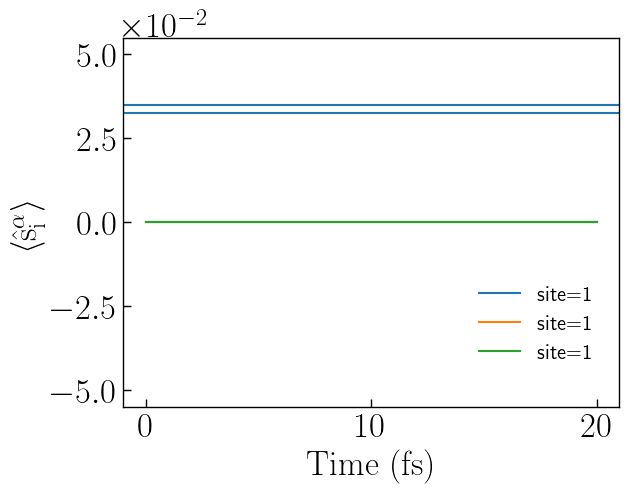

PyObject <matplotlib.lines.Line2D object at 0x7fb82b267a70>

In [51]:

fig,axs =  plt.subplots(1,1)
site = 1
sites = range(1,6)
# for i in site 
#     axs.plot(ts_cd, cden_ta1[:,i]*det,label= "site=$(i)")#,alpha =1-0.2*i ) ### Charge bound current
#     axs.plot(ts_cd, cden_ta1[:,i+1]*det,label= "site=$(i+1)")#
# end
axs.plot(sol.t, sd[:,1],label= "site=$(1)")#,alpha =1-0.2*i ) ### Charge bound current
axs.plot(sol.t, sd[:,2],label= "site=$(1)")
axs.plot(sol.t, sd[:,3],label= "site=$(1)")
#axs.plot(sol.t, sd[:,6],label= "site=$(1)")
#axs.plot(sol.t, -cd[:,3],label= "site=$(1)",ls = "--")#
#axs.plot(sol.t, cd[:,3].+cd[:,4],label= "site=$(2)")

axs.set_ylabel(raw"$\langle\mathrm{\hat{s}^{\alpha}_i}\rangle$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.1))
#plt.ylim(2e-2-0.1e-2,2e-2+0.2e-2)
plt.axhline(0.035)

#plt.axhline(0.013)#plt.axhline(0.035)
plt.axhline(0.0325)
#plt.axhline(0.002)
#plt.ylim(0.035-0.01,0.035+0.01)
#plt.ylim(0.0,0.05)
# plt.xlim(70,80)
#plt.xlim(50,120)
#plt.axhline(0.5,ls = "--",color="gray",lw = 0.5)

In [63]:
G = GL[100,2]
sz1_sigma = real(-0.5im * ((σ_ijx[:,:,3]*G)[1,1] + (σ_ijx[:,:,3]*G)[2,2]))
sz1_diag  = 0.5 * (imag(G[1,1]) - imag(G[2,2]))

2.2370800848121594e-8

In [102]:
#99/100
sz1_sigma = real(-0.5im * ((σ_ijx[:,:,3]*G)[1,1] + (σ_ijx[:,:,3]*G)[2,2]))

9.845168240865955e-9

### Local density 

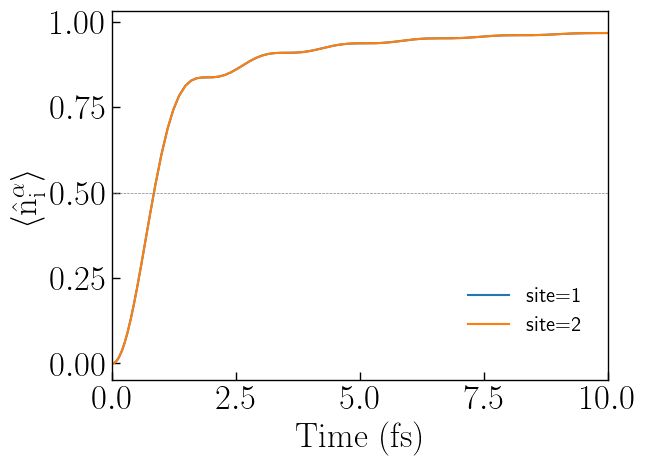

(0.0, 10.0)

In [53]:

fig,axs =  plt.subplots(1,1)
site = 2
sites = range(1,6)
# for i in site 
#     axs.plot(ts_cd, cden_ta1[:,i]*det,label= "site=$(i)")#,alpha =1-0.2*i ) ### Charge bound current
#     axs.plot(ts_cd, cden_ta1[:,i+1]*det,label= "site=$(i+1)")#
# end
axs.plot(sol.t, cd[:,1]+cd[:,2],label= "site=$(1)")#,alpha =1-0.2*i ) ### Charge bound current
#axs.plot(sol.t, -cd[:,3],label= "site=$(1)",ls = "--")#
axs.plot(sol.t, cd[:,3].+cd[:,4],label= "site=$(2)")

axs.set_ylabel(raw"$\langle\mathrm{\hat{n}^{\alpha}_i}\rangle$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.1))
#plt.xlim(100,120)
plt.axhline(0.5,ls = "--",color="gray",lw = 0.5)
plt.xlim(0,10)
#plt.ylim(1-0.05,1+0.05)

In [52]:
#cc[:,1]

### Charge current 

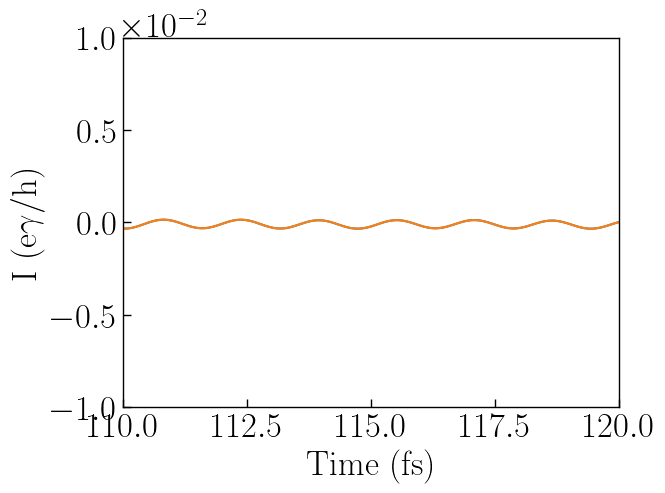

(110.0, 120.0)

In [127]:
fig,axs = plt.subplots(1,1)

plt.plot(sol.t, cc[:,1])
plt.plot(sol.t, cc[:,2])
axs.set_ylabel(L"$\mathrm{I\ (e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.01,  0.8))
#plt.xlim(30,80)
plt.axhline(0.1,ls = "--",lw=0.5)
plt.axhline(-0.1,ls = "--",lw=0.5)
#plt.axhline(0.0,ls = "--",lw=0.5)
#plt.axhline(0.05,ls = "--",lw=0.5)
plt.ylim(-2,6.5)
plt.show()
#plt.ylim(-0.05,0.05)
plt.ylim(-1e-2,1e-2)


#plt.ylim(0.1-1e-2,0.1+1e-2)
plt.xlim(110,120)

### Spin current

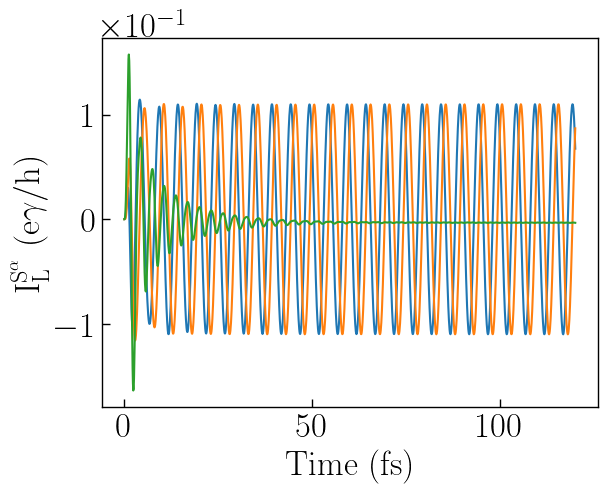

PyObject <matplotlib.legend.Legend object at 0x7fa65dff6c00>

In [128]:
fig,axs = plt.subplots(1,1)

plt.plot(sol.t, sc[:,1])
plt.plot(sol.t, sc[:,2])
plt.plot(sol.t, sc[:,3])
axs.set_ylabel(L"$\mathrm{I_L^{S^{\alpha}}\ (e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.01,  0.8))

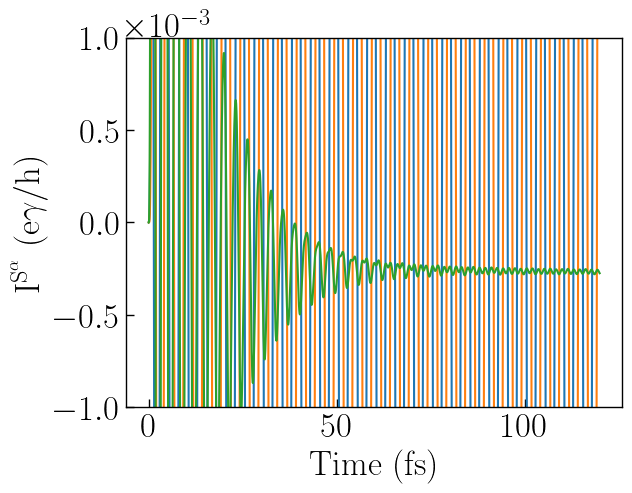

(-0.001, 0.001)

In [129]:
fig,axs = plt.subplots(1,1)

plt.plot(sol.t, C_l_x)
plt.plot(sol.t, C_l_y)
plt.plot(sol.t, C_l_z)
axs.set_ylabel(L"$\mathrm{I^{S^{\alpha}}\ (e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.01,  0.8))
plt.ylim(-0.001,0.001)

In [71]:


# using DelimitedFiles
# cc_f = open("/home/jalil2/Documents/KBA/data/curr_KBE_jl.txt", "w+") 

# writedlm(cc_f, [sol.t Curr_left], ' ' )

# close(cc_f)

### Check

In [99]:
#sol.w

In [111]:
@code_warntype integrate1(sol.w, 10, 7, ΣG, ΣL, GL)
@code_warntype integrate2(sol.w, 10, 7, ΣL, GL, GG)

MethodInstance for integrate1(::Vector{Vector{Float64}}, ::Int64, ::Int64, ::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, SkewHermitian}, ::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, SkewHermitian}, ::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, SkewHermitian})
  from integrate1(hs::Vector, t1, t2, A::GreenFunction, B::GreenFunction, C::GreenFunction; tmax) @ Main In[5]:10
Arguments
  #self#::Core.Const(Main.integrate1)
  hs::Vector{Vector{Float64}}
  t1::Int64
  t2::Int64
  A::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, SkewHermitian}
  B::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, SkewHermitian}
  C::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, SkewHermitian}
Body::Matrix{ComplexF64}
 %1 = Main.:(var"#integrate1#6")::Core.Const(Main.var"#integrate1#6")
%1)(t1, #self#, hs, t1, t2, A, B, C)::Matrix{ComplexF64}
└──      return %2

MethodInstance for integrate2(::Vector{Vector{Float64}}, ::Int64, ::Int64, ::GreenFunction{ComplexF64, 4, Array{Compl

In [94]:
@assert eltype(GL[1,1]) <: Complex    # bloques complejos
@assert eltype(GG[1,1]) <: Complex
@assert eltype(ΣL[1,1]) <: Complex && eltype(ΣG[1,1]) <: Complex

In [97]:
# === s_z de equilibrio por sitio (usa selfenergy de tu código) ===
function s_eq_z(H; γ=γ, γcL=1.0, γcR=1.0, μ=0.0, T=0.05, kB=1.0,
                dε=1e-3, η=1e-12, Eband=nothing)
    # H: Hamiltoniano 4x4 del dímero (2 sitios × 2 spins)
    # γ, γcL, γcR: hopping de lead 1D y acoplos a L/R
    # μ, T, kB   : químicos y temperatura (en T-unidades compatibles con H)
    # dε, η      : paso de energía y ancho infinitesimal para GR
    # Eband      : semiancho de integración; por defecto 2γ

    n = size(H,1)              # debe ser 2*2 = 4
    @assert n % 2 == 0 "H debe tener bloques 2×2 por sitio (spin)"
    ns = div(n,2)              # número de sitios (2)
    I2 = Matrix{ComplexF64}(I, 2, 2)
    In = Matrix{ComplexF64}(I, n, n)
    σz_full = σ_ijx[:,:,3]     # ya la tienes definida: diag(1,-1,1,-1)
    if Eband === nothing
        Eband = 2γ             # borde de banda del 1D
    end

    εs = -Eband:dε:Eband
    w  = ones(length(εs)); w[1] = 0.5; w[end] = 0.5   # trapecio

    s = zeros(Float64, ns)

    for (j, ε) in enumerate(εs)
        # Σ^R embebidas por sitio (bloques 2×2 en [1:2,1:2] y [3:4,3:4])
        ΣLε = selfenergy(ε; γ=γ, γc=γcL)
        ΣRε = selfenergy(ε; γ=γ, γc=γcR)

        ΣR = zeros(ComplexF64, n, n)
        ΣR[1:2, 1:2]                 .+= ΣLε * I2
        ΣR[n-1:n, n-1:n]             .+= ΣRε * I2

        # Retardado/avanzado y Γ total
        GR = inv((ε + 1im*η)*In - H - ΣR)
        GA = GR'
        Γ  = zeros(ComplexF64, n, n)
        Γ[1:2, 1:2]                  .+= (-2*imag(ΣLε)) * I2
        Γ[n-1:n, n-1:n]              .+= (-2*imag(ΣRε)) * I2

        f = 1.0 / (1.0 + exp((ε - μ)/(kB*T)))   # Fermi(ε)

        X = GR * (Γ * f) * GA   # matriz 4x4 que pesa las contribuciones

        # s_z por sitio: (1/2) * tr_spin(σ_z * X_ii)
        for i in 1:ns
            off = 2*(i-1)
            Xi  = X[off+1:off+2, off+1:off+2]
            s[i] += w[j] * real(tr(σ_z * Xi))
        end
    end

    s .*= dε/(2π)
    return s   # devuelve [s_z^eq(sitio 1), s_z^eq(sitio 2)]
end


s_eq_z (generic function with 1 method)

In [ ]:
s_eq_z(H0; γ=γ, γcL=1.0, γcR=1.0, T=300, kB=8.6173324e-5)

In [105]:
function s_eq_z(H; γ=γ, γcL=1.0, γcR=1.0,
                μL=0.0, μR=0.0, TL=0.05, TR=0.05, kB=1.0,
                dε=1e-3, η=1e-12, Eband=2γ)
    n   = size(H,1); ns = div(n,2)
    I2  = Matrix{ComplexF64}(I, 2, 2)
    In  = Matrix{ComplexF64}(I, n, n)
    εs  = -Eband:dε:Eband
    w   = ones(length(εs)); w[1]=0.5; w[end]=0.5
    s   = zeros(Float64, ns)

    fF(ε, μ, T) = 1 / (1 + exp((ε-μ)/(kB*T)))

    for (j, ε) in enumerate(εs)
        ΣLε = selfenergy(ε; γ=γ, γc=γcL)
        ΣRε = selfenergy(ε; γ=γ, γc=γcR)

        ΣR  = zeros(ComplexF64, n, n)
        ΣR[1:2, 1:2]             .+= ΣLε * I2
        ΣR[n-1:n, n-1:n]         .+= ΣRε * I2

        ΓL  = (-2*imag(ΣLε)) * I2
        ΓR  = (-2*imag(ΣRε)) * I2

        GR  = inv((ε + 1im*η)*In - H - ΣR)
        GA  = GR'

        M   = zeros(ComplexF64, n, n)
        M[1:2, 1:2]              .+= ΓL * fF(ε, μL, TL)
        M[n-1:n, n-1:n]          .+= ΓR * fF(ε, μR, TR)

        X   = GR * M * GA   # matriz 4x4
        # s_z por sitio: (1/2) tr_spin(σ_z * X_ii)
        for i in 1:ns
            off = 2*(i-1)
            Xi  = X[off+1:off+2, off+1:off+2]
            s[i] += w[j] * real(tr(σ_z * Xi))
        end
    end
    s .*= dε/(2π)
    return s
end


s_eq_z (generic function with 1 method)

In [111]:
H0 = hs_t(100)                 # tu función ya definida
KB = 8.6173324e-5
s_eq = s_eq_z(H0;  γ=γ, γcL=1.0, γcR=1.0,
                μL=0.0, μR=0.0, TL=300, TR=300,
                dε=1e-2, η=1e-12, Eband=2γ, kB=8.6173324e-5)

2-element Vector{Float64}:
 -0.04852953263389707
 -0.048529532633897074

In [130]:
s_eq*0.73

2-element Vector{Float64}:
 -0.035426558822744855
 -0.03542655882274486

In [150]:
hs_t(0)#[1:2,1:2]   

4×4 Matrix{ComplexF64}:
 -0.0965926+0.0im  -0.0258819+0.0im        -1.0+0.0im         0.0+0.0im
 -0.0258819+0.0im   0.0965926+0.0im         0.0+0.0im        -1.0+0.0im
       -1.0+0.0im         0.0+0.0im  -0.0965926+0.0im  -0.0258819+0.0im
        0.0+0.0im        -1.0+0.0im  -0.0258819+0.0im   0.0965926+0.0im

In [134]:
pi/5

0.6283185307179586

In [ ]:
#hs_t(13.5)
#vm_i1x
ts= 0.0:0.1:120
function test_prec(t)
    theta_1, phi_1 = 15.0 , 0.0#45.0, 0.0 
    period = 10 
    pr_spins = [PrecSpin(i) for i in 1:1:L  ]        ### array with mutables object of preccesin spins
    for jj in 1: L
        pr_spins[jj].i = jj ## lattice site 
        pr_spins[jj].theta_zero = theta_1
        pr_spins[jj].axis_phi = phi_1
        pr_spins[jj].T = period 
        #println(pr_spins[jj].i)
    end

    vm_i1x = zeros(Float64,nx*ny,3)
    for j in 1:1:nx #3:1:5#n_precessing#length(pr_spins)
        #println(j)
        #dv.vm_i1x[2,:] .= zeros(Float64,3)
        update!(pr_spins[j], t )
        vm_i1x[pr_spins[j].i,:] .= pr_spins[j].s
    end   
    return vm_i1x
end

In [171]:
sx(t) = test_prec(t)[1,1]
sy(t) = test_prec(t)[1,2]
sz(t) = test_prec(t)[1,3]
#plt.plot(ts,sx.(ts))
sxx = sx.(ts)
syy = sy.(ts)

s2x(t) = test_prec(t)[2,1]
s2y(t) = test_prec(t)[2,2]
s2z(t) = test_prec(t)[2,3]
#plt.plot(ts,sx.(ts))
s2xx = s2x.(ts)
s2yy = s2y.(ts);

In [177]:
(sc[end,1]+sc[end,4])*0.6/(4pi)

0.0012598804088289233

In [172]:

torque = j_sd*(sxx[end]*sd[end,2] -  syy[end]*sd[end,1] + s2xx[end]*sd[end,5] - s2yy[end]*sd[end,4])

-0.00013177711266729728

In [178]:
sxx[end]

0.25881904510252074

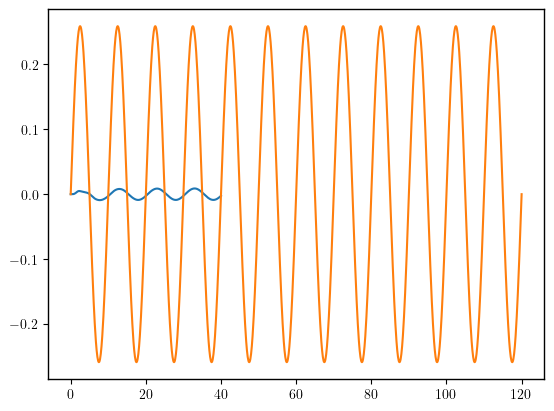

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe72fec9b80>

In [184]:
plt.plot(sol.t,sd[:,2])
plt.plot(ts, s2yy)

In [64]:
# # Continuidad de carga: I_L + I_R + dQ_C/dt ≈ 0
# Q = [cd1[t] + cd2[t] + cd3[t] + cd4[t] for t in eachindex(sol.t)]
# dt = diff(sol.t)                      # puede ser no uniforme
# dQ = [ (Q[k+1]-Q[k]) / dt[k] for k in 1:length(dt) ]
# cont_err = ((Curr_left[2:end] .+ Curr_right[2:end])/(2pi) .+ dQ)  # ~ 0
# @info "max |continuidad| = $(maximum(abs.(cont_err)))"

# # Skew-Herm de G<(t,t'): max |G<(t,t') + G<†(t',t)|
# function check_skewherm(G; tol=1e-8)
#     nt = size(G,3)
#     m = 0.0
#     for t1 in 1:nt, t2 in 1:nt
#         m = max(m, maximum(abs.(G[:,:,t1,t2] .+ adjoint(G[:,:,t2,t1]))))
#     end
#     @info "max skew-Herm G<: $m";  m < tol || @warn "violación skew-Herm grande"
# end
# # check_skewherm(data.GL)

# dQ

In [65]:
#(Curr_left[2:end] .+ Curr_right[2:end])/(2pi)

In [72]:
# using DelimitedFiles
# ccL_f = open("./data/ccL_KBE_jl.txt", "w+") 
# ccR_f = open("./data/ccR_KBE_jl.txt", "w+") 
# writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
# writedlm(ccR_f, [sol.t*hbar 4pi*Curr_right], ' ' )
# close(ccL_f)
# close(ccR_f)

In [73]:
#sol.t*hbar
#[sol.t*hbar  4pi*Curr_left]

In [74]:
#4pi*Curr_left[end]/0.05

In [75]:
#4pi*Curr_left[end]

In [76]:
#0.1/0.05
#0.096742516300053/0.05

In [77]:
#plt.plot(sol.t, Curr_right)

In [78]:
#0.05/0.2

## Save data 

In [130]:
using DelimitedFiles
path = "/home/jalil2/Documents/KBA/data"
name = "KBE_33";

### Spin density 

In [131]:
sd_f = open("$(path)/sd_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(sd_f, [sol.t sd], ' ' )
#writedlm(ccR_f, [ts_cc -4*pi*cc_αt[1,:]], ' ' )
#close(ccL_f)
close(sd_f)

### Spin current

In [132]:
sc_f = open("$(path)/sc_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(sc_f, [sol.t sc], ' ' )
#writedlm(ccR_f, [ts_cc -4*pi*cc_αt[1,:]], ' ' )
#close(ccL_f)
close(sc_f)

### Charge current 

In [59]:
#ccL_f = open("./data/ccL_GKBA_jl.txt", "w+") 
cc_f = open("$(path)/cc_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(cc_f, [sol.t cc], ' ' )
#writedlm(ccR_f, [ts_cc -4*pi*cc_αt[1,:]], ' ' )
#close(ccL_f)
close(cc_f)

### Local density 

In [60]:
cden_f = open("$(path)/cd_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(cden_f, [sol.t cd], ' ' )
#close(ccL_f)
close(cden_f)